In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from torch import nn
from scipy.spatial import cKDTree
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# df = pd.read_csv(file_dir)
# column_names = df.columns
# print(column_names)
# df.iloc[0]

In [3]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [4]:
cv_names = {'CORNELL ID',
            ' OFF (pre-dbs updrs)',
            ' ON (pre-dbs updrs)',
            ' OFF meds ON stim 6mo',
            ' BDI ON',
            ' BAI OFF',
            ' BDI OFF',
            'Starkstein Apathy Off',
            ' postop bdi (on)',
            'Age',
            'Sex',
            'Ethnicity',
            'Race',
            'Disease Duration (year)',
            'Physician',
            ' pre op levadopa equivalent dose (mg)',
            ' Location',
            ' Target',
            ' Test medication status',
            'POST-OP (6 MONTHS): 6 mo levadopa equivalent dose (mg)'
            }


# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/dbs_03292024.csv'
motor_df = util.filter_data(file_dir,cv_names,True)
# Find cases with all required scores
cv_dict = util.filter_cases(motor_df,cv_names)
subs = cv_dict['CORNELL ID']
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/new/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/new/phi/'
roi_path = '/home/ali/RadDBS-QSM/data/xlxs/new_segs.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
print(np.unique(R_all))
ids = np.asarray(ID_all).astype(int)

# Use cases from only 1 rater
phys = cv_dict['Physician']
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(ids).astype(int),np.asarray(cv_dict['CORNELL ID']).astype(int))#[phys==1].astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
# Exclude GPi
c_cases_idx[ids == 36] = 0
c_cases_idx[ids == 53] = 0
c_cases_idx[ids == 98] = 0
c_cases_idx[ids == 108] = 0
# Exclude infinite BDI
c_cases_idx[ids == 16] = 0
c_cases_idx[ids == 45] = 0
c_cases_idx[ids == 46] = 0
c_cases_idx[ids == 78] = 0
print(np.sum(c_cases_idx))
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
print(len(s_cases_idx))
        
X_all_c = X_all[c_cases_idx,4:6,:]
#X_all_c = (np.load('X2h_sr.npy').T).reshape((31,6381))
# print('Applying combat')
K_all_c = K_all[c_cases_idx,4:6,:]
R_all_c = R_all[c_cases_idx,4:6,:]
# Re-index the scored subjects with respect to complete cases

per_change = ((cv_dict[' BDI OFF']-cv_dict[' postop bdi (on)'])/cv_dict[' BDI OFF'])[s_cases_idx]
per_change_u = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' OFF meds ON stim 6mo'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_imp_u = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_imp = ((cv_dict[' BDI OFF']-cv_dict[' BDI ON'])/cv_dict[' BDI OFF'])[s_cases_idx]
pre_updrs = cv_dict[' OFF (pre-dbs updrs)'][s_cases_idx]
dd = cv_dict['Disease Duration (year)'][s_cases_idx]
ledd = cv_dict[' pre op levadopa equivalent dose (mg)'][s_cases_idx]
tmed = cv_dict[' Test medication status'][s_cases_idx]
pre_bdi = cv_dict[' BDI OFF'][s_cases_idx]
pre_sas = cv_dict['Starkstein Apathy Off'][s_cases_idx]
pre_bai = cv_dict[' BAI OFF'][s_cases_idx]
age = cv_dict['Age'][s_cases_idx]
loc = cv_dict[' Location'][s_cases_idx]
sex = cv_dict['Sex'][s_cases_idx]
rce = cv_dict['Race'][s_cases_idx]
eth = cv_dict['Ethnicity'][s_cases_idx]
tgt = cv_dict[' Target'][s_cases_idx]
phys = cv_dict['Physician'][s_cases_idx]
p_ledd = cv_dict['POST-OP (6 MONTHS): 6 mo levadopa equivalent dose (mg)'][s_cases_idx]
subsc = subs[s_cases_idx]
    
# Reshape keys and ROIs
all_rois = False
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K_all_cu[:,:,-1] = 'disease_duration'
    K_all_cu[:,:,-1] = 'pre op levadopa equivalent dose (mg)'
    K_all_cu[:,:,-1] = ' Test medication status'
    K_all_cu[:,:,-1] = 'Physician'
    K_all_cu[:,:,-1] = 'Age'
    K_all_cu[:,:,-1] = 'Location'
    K_all_cu[:,:,-1] = 'Sex'
    K_all_cu[:,:,-1] = 'Race'
    K_all_cu[:,:,-1] = 'Ethnicity'
    
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
# else:
#     K_all_c = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
#     R_all_c = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))

print(np.unique(R_all_c))

CORNELL ID
Keeping CORNELL ID
DOB
Age
Keeping Age
Sex
Keeping Sex
Ethnicity
Keeping Ethnicity
Race
Keeping Race
Disease Duration (year)
Keeping Disease Duration (year)
Physician
Keeping Physician
Starkstein Apathy Off
Keeping Starkstein Apathy Off
Starkstein Apathy ON
 BDI OFF
Keeping  BDI OFF
 BDI ON
Keeping  BDI ON
 BAI OFF
Keeping  BAI OFF
 BAI ON
 QUIP OFF
 QUIP ON
 total_pdq
 OFF (pre-dbs updrs)
Keeping  OFF (pre-dbs updrs)
 ON (pre-dbs updrs)
Keeping  ON (pre-dbs updrs)
 pre op levadopa equivalent dose (mg)
Keeping  pre op levadopa equivalent dose (mg)
 mri (pre-op)
 1st Lead Date
 Location
Keeping  Location
 Target
Keeping  Target
 Test medication status
Keeping  Test medication status
POST-OP (6 MONTHS): 6 mo levadopa equivalent dose (mg)
Keeping POST-OP (6 MONTHS): 6 mo levadopa equivalent dose (mg)
 OFF meds ON stim 6mo
Keeping  OFF meds ON stim 6mo
 ON meds ON stim 6mo
 off stim on med 6mo
 off stim off med 6mo
 apathy off 6mo
 apathy on 6 mo
 postop bdi (off)
 postop bdi (o

/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide


In [5]:
R_all_c.shape

(25, 2, 1595)

In [6]:
n_features = 1596
n_rois = 6
K_all_c = np.char.add(K_all_c[0,:,:].reshape(-1,1),' ')
R_all_c = np.char.add(R_all_c[0,:,:].reshape(-1,1),' ')
# K_all_c = np.char.add(np.squeeze(K_all_c),np.squeeze(R_all_c))
print(K_all_c.shape)
# R_all_c = np.repeat(R[1:5],n_features-1)
# K_all_c = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]))[0]
# R_all_c = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))


K_all_c = np.append(K_all_c,['pre-bdi'])
R_all_c = np.append(R_all_c,['pre-updrs'])
K_all_c = np.append(K_all_c,['age'])
R_all_c = np.append(R_all_c,['age'])
K_all_c = np.append(K_all_c,['tmed'])
R_all_c = np.append(R_all_c,['tmed'])
K_all_c = np.append(K_all_c,['ledd'])
R_all_c = np.append(R_all_c,['ledd'])
K_all_c = np.append(K_all_c,['age'])
R_all_c = np.append(R_all_c,['age'])
K_all_c = np.append(K_all_c,['disease duration'])
R_all_c = np.append(R_all_c,['disease duration'])
K_all_c = np.append(K_all_c,['loc'])
R_all_c = np.append(R_all_c,['loc'])
K_all_c = np.append(K_all_c,['phys'])
R_all_c = np.append(R_all_c,['phys'])
K_all_c = np.append(K_all_c,['sex'])
R_all_c = np.append(R_all_c,['sex'])
print(R_all_c.shape)
# K_all_c = np.char.add(np.squeeze(K_all_c),np.squeeze(R_all_c))
print(K_all_c.shape)

(3190, 1)
(3199,)
(3199,)


In [7]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(file_dir)
df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,POST-OP (6 MONTHS),Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38
0,CORNELL ID,DOB,Age,Sex,Ethnicity,Race,Disease Duration (year),Physician,Starkstein Apathy Off,Starkstein Apathy ON,BDI OFF,BDI ON,BAI OFF,BAI ON,QUIP OFF,QUIP ON,total_pdq,OFF (pre-dbs updrs),ON (pre-dbs updrs),pre op levadopa equivalent dose (mg),mri (pre-op),1st Lead Date,Location,Target,Test medication status,6 mo levadopa equivalent dose (mg),OFF meds ON stim 6mo,ON meds ON stim 6mo,off stim on med 6mo,off stim off med 6mo,apathy off 6mo,apathy on 6 mo,postop bdi (off),postop bdi (on),postop bai (off),postop bai (on),postop quip (off),postop quip (on),pdq_post
1,1,12/31/57,63,0,2,0,5,2,13,8,47,27,47,42,26,35,48.3,65,20,181.8,03/08/21,3/25/2021,0,0,0,0,19,NaN,NaN,42,NaN,21,NaN,23,NaN,35,NaN,24,NaN
2,2,03/19/55,66,0,2,2,7,5,2,2,5,7,2,3,0,0,8.6,22,7,1200,07/19/21,7/30/2021,0,0,0,0,11,NaN,NaN,48,NaN,3,NaN,5,NaN,1,NaN,4,1.8
3,6,02/10/74,46,0,2,2,8,1,12,22,25,34,4,13,0,4,44.8,63,32,400,02/08/21,2/25/2021,0,0,0,0,21,NaN,NaN,17,NaN,14,NaN,18,NaN,4,NaN,8,NaN
4,7,05/28/46,74,0,2,2,11,0,3,2,NaN,12,5,8,10,31,25.6,31,8,1450,07/27/20,8/6/2020,0,0,1,300,7,5,NaN,NaN,NaN,11,NaN,5,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,112,04/06/50,72,0,2,2,5,2,NaN,7,NaN,10,NaN,15,NaN,NaN,NaN,54,28,850,8/12/2022,8/12/2022,0,0,0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,113,06/09/73,49,1,2,2,5,1,16,16,14,8,13,1,44,13,23.8,38,18,1350,7/11/2022,7/18/2022,0,0,1,100,15,7,NaN,NaN,6,9,5,0,10,6,14,4,29.2
68,114,04/27/54,68,1,2,2,8,1,12,3,9,0,2,0,0,0,12.4,40,16,300,9/19/2022,9/23/2022,0,0,1,100,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,115,12/19/55,66,0,2,2,10,1,11,6,7,7,12,6,2,3,34.8,39,19,900,10/31/2022,12/1/2022,0,0,0,0,15,NaN,NaN,NaN,11,13,22,14,13,11,3,0,17.8


In [8]:
def flatten(xss):
    return [x for xs in xss for x in xs]


In [9]:
m = util.exclude_outliers(per_change)
print(per_change_u)
print(per_change)
per_change = per_change[m]
per_change_u = per_change_u[m]
print(per_change_u)
print(per_change)
subsc = subsc[m]
X_all_c = X_all_c[m,:,:]
X_all_c.shape

Upper bound of 0.7432432432432432
Lower bound of -0.44594594594594594
Excluded 6 outliers
[0.70769231 0.5        0.66666667 0.96825397 0.73809524 0.71428571
 0.8125     0.88461538 0.3030303  0.075      0.81081081 0.76086957
 0.55932203 0.52272727 0.83928571 0.08571429 0.30232558 0.45614035
 0.96       0.71111111 0.69491525 0.61702128 0.60655738 0.60526316
 0.61538462]
[ 0.5106383   0.          0.28        0.11111111  0.2972973   0.17391304
  0.21212121  0.          0.14285714  0.79487179  0.23809524  0.96875
  0.25        0.16666667 -0.08333333  0.25        0.88235294 -1.8
  0.45454545 -0.26666667 -0.33333333  0.17391304 -0.30769231  1.
 -1.        ]
[0.70769231 0.5        0.66666667 0.96825397 0.73809524 0.71428571
 0.8125     0.88461538 0.3030303  0.81081081 0.55932203 0.52272727
 0.83928571 0.08571429 0.96       0.71111111 0.69491525 0.61702128
 0.60655738]
[ 0.5106383   0.          0.28        0.11111111  0.2972973   0.17391304
  0.21212121  0.          0.14285714  0.23809524  0.25

(19, 2, 1595)

In [10]:
n_cases = len(per_change)
results_ls_aug = np.zeros_like(np.vstack((per_change,per_change)).T)
results_ls = np.zeros_like(per_change)
r = 1

In [11]:
Js = []
aug = True
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
K_nz_m = []
K_nz_nm = []
w_nz_nm = []
p_nz = []
c = 0
K_all_c = np.append(K_all_c,'pre_bdi')
for j in np.arange(c,len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train_nm = per_change[train_index]
    y_train_m = per_change_u[train_index]
    y_test = per_change[test_index]
    (mu_m, sigma_m) = stats.norm.fit(y_train_m)
    (mu_nm, sigma_nm) = stats.norm.fit(y_train_nm)
    yc = 0.35
    y_cat = y_train_m <= yc
    idym = np.where(y_cat==1)
    y_cat = y_train_m <= yc
    idym = np.where(y_cat==1)
    # Cross validation
    # Remove LCT results
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_bdi[m],pre_updrs[m],age[m],tmed[m],ledd[m],age[m],dd[m],loc[m],phys[m],sex[m],False,False,False)
                                                #pre_bai[m],pre_bdi[m],pre_sas[m],pre_updrs[m],tmed[m],ledd[m],age[m],dd[m],loc[m],phys[m],False,False,False)
    cvn = 5
    cv_scores = np.zeros((cvn,1))
    rs = 1

    while np.sum(y_cat) < cvn:
      np.random.seed(rs)
      idyrm = np.random.choice(np.asarray(idym).ravel())
      X0_ss0 = np.append(X0_ss0,X0_ss0[idyrm,:].reshape(1,-1),axis=0)
      y_train_m = np.append(y_train_m,y_train_m[idyrm])
      y_train_nm = np.append(y_train_nm,y_train_nm[idyrm])
      y_cat = y_train_m <= yc
      rs = rs+1
      print('Resampled to size',y_train_m.shape)
    y_train = np.vstack((y_train_nm,y_train_m)).T
    Q = 3
    X0_ss0_n = X0_ss0
    for j in np.arange(Q):
      if aug == True:
        np.random.seed(rs)
        y_train_n = np.vstack((y_train_nm+(3*sigma_nm)*np.random.normal(0,1,1),y_train_m+(3*sigma_m)*np.random.normal(0,1,1))).T
        y_train = np.vstack((y_train,y_train_n))
        print(y_train_n.shape)
        y_cat = y_train <= yc
        X0_ss0 = np.vstack((X0_ss0,X0_ss0_n))
        print('Augmented to size',y_train.shape,X0_ss0.shape)
    
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
      sel = skf.SelectKBest(skf.f_regression,k=5)
      X0_sst = sel.fit_transform(X0_ss0,y_train[:,1])
      X0_ss = X0_sst
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      X_test_sst = sel.transform(X_test_ss0)
      X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      np.seterr(divide='ignore', invalid='ignore')
      lasso = MultiOutputRegressor(slm.LassoLarsCV(cv=5,normalize=False,eps=0.1))
      est_ls = lasso.fit(X0_ss,y_train)
      results_ls_aug[c,1] = est_ls.predict(X_test_ss)[0][1]
      print('Lasso predicts nonmotor and motor:',str(np.round(results_ls_aug[c],4)),
            'for case with BDI',str(np.round(np.repeat(per_change,r)[c],2)),'and UPDRS',str(np.round(np.repeat(per_change_u,r)[c],2)))#,'compared to LCT',pre_imp[m][c])
      print(K_all_c.shape)
      K_nz_m.append(np.squeeze(sel.transform(K_all_c.reshape(1,-1)))[est_ls.estimators_[1].coef_ != 0])
      
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
      sel = skf.SelectKBest(skf.f_regression,k=5)
      X0_sst = sel.fit_transform(X0_ss0,y_train[:,0])
      X0_ss = X0_sst
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      X_test_sst = sel.transform(X_test_ss0)
      X_test_ss = X_test_sst
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      np.seterr(divide='ignore', invalid='ignore')
      lasso = MultiOutputRegressor(slm.LassoLarsCV(cv=5,normalize=False,eps=0.1))
      est_ls = lasso.fit(X0_ss,y_train)
      results_ls_aug[c,0] = est_ls.predict(X_test_ss)[0][0]
      print('Lasso predicts nonmotor and motor:',str(np.round(results_ls_aug[c],4)),
            'for case with BDI',str(np.round(np.repeat(per_change,r)[c],2)),'and UPDRS',str(np.round(np.repeat(per_change_u,r)[c],2)))#,'compared to LCT',pre_imp[m][c])
      K_nz_nm.append(np.squeeze(sel.transform(K_all_c.reshape(1,-1)))[est_ls.estimators_[0].coef_ != 0])
      w_nz_nm.append(est_ls.estimators_[0].coef_[est_ls.estimators_[0].coef_ != 0])
      print(np.sum([est_ls.estimators_[0].coef_ != 0]))
      p_nz.append(np.sum([est_ls.estimators_[0].coef_ != 0])*[per_change[c]>=0])
    c=c+1


      

  


Resampled to size (19,)
Resampled to size (20,)
Resampled to size (21,)
(21, 2)
Augmented to size (42, 2) (42, 3200)
(21, 2)
Augmented to size (63, 2) (63, 3200)
(21, 2)
Augmented to size (84, 2) (84, 3200)
Lasso predicts nonmotor and motor: [0.     0.8452] for case with BDI 0.51 and UPDRS 0.71
(3200,)
Lasso predicts nonmotor and motor: [0.1223 0.8452] for case with BDI 0.51 and UPDRS 0.71
4
Resampled to size (19,)
Resampled to size (20,)
Resampled to size (21,)
(21, 2)
Augmented to size (42, 2) (42, 3200)
(21, 2)
Augmented to size (63, 2) (63, 3200)
(21, 2)
Augmented to size (84, 2) (84, 3200)
Lasso predicts nonmotor and motor: [0.     0.9285] for case with BDI 0.0 and UPDRS 0.5
(3200,)
Lasso predicts nonmotor and motor: [0.2796 0.9285] for case with BDI 0.0 and UPDRS 0.5
4
Resampled to size (19,)
Resampled to size (20,)
Resampled to size (21,)
(21, 2)
Augmented to size (42, 2) (42, 3200)
(21, 2)
Augmented to size (63, 2) (63, 3200)
(21, 2)
Augmented to size (84, 2) (84, 3200)
Lasso p

Text(0.5, 1.0, 'Nonmotor')

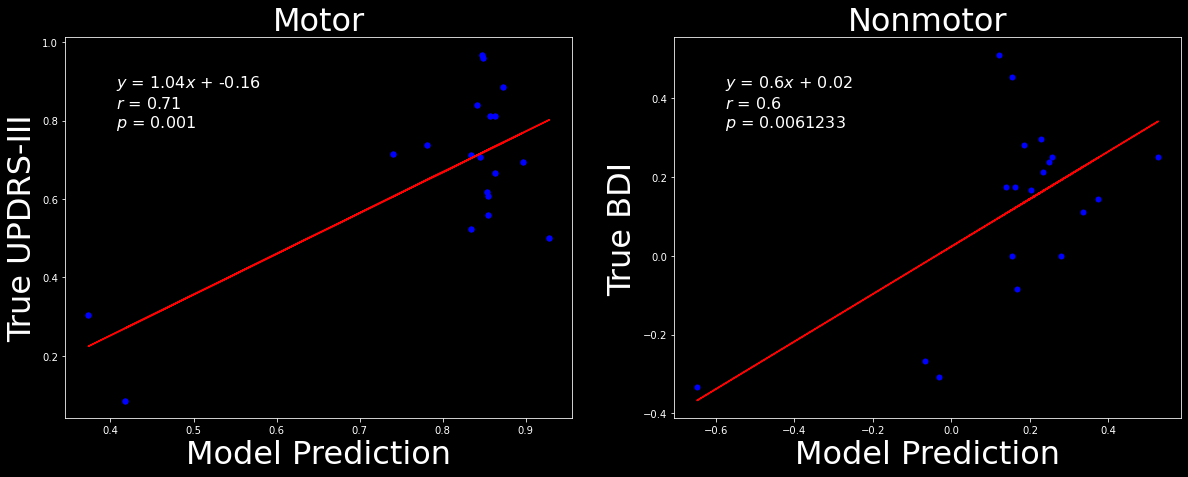

In [12]:
plt.rcParams['figure.figsize'] = [20, 7]
col = 'blue'
fig,ax = plt.subplots(1,2,sharex=False,sharey=False)
ax[0].scatter(results_ls_aug[:,1],per_change_u, c=col,linewidth=0)
lr = stats.linregress(results_ls_aug[:,1],per_change_u)
y_model = results_ls_aug[:,1]*lr.slope+lr.intercept
ax[0].scatter(results_ls_aug[:,1],per_change_u, c=col,linewidth=0)
ax[0].plot(results_ls_aug[:,1],y_model,color='r')
ax[0].text(0.1,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0].transAxes,fontsize=16)  
ax[0].set_title('Motor',fontsize=32)
ax[0].set_ylabel('True UPDRS-III',fontsize=32)
ax[0].set_xlabel('Model Prediction',fontsize=32)
#col = np.where(per_change <= 0.3,'orange','blue')
ax[1].scatter(results_ls_aug[:,0],per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug[:,0]),per_change)
y_model = results_ls_aug[:,0]*lr.slope+lr.intercept
ax[1].plot(results_ls_aug[:,0],y_model,color='r')
ax[1].text(0.1,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=16) 
ax[1].set_xlabel('Model Prediction',fontsize=32)
ax[1].set_ylabel('True BDI',fontsize=32)
ax[1].yaxis.set_tick_params(labelleft=True)
ax[1].set_title('Nonmotor',fontsize=32)

In [13]:
# k = 50
# r = 0.69, 0.46
# k = 20
# r = 0.75, 0.42
# k = 200
# r = 0.47, -0.05
# k = 10
# r = 0.71, 0.3
# k = 15
# r = 0.76, 0.45
# k = 100
# r = 0.53, -0.03



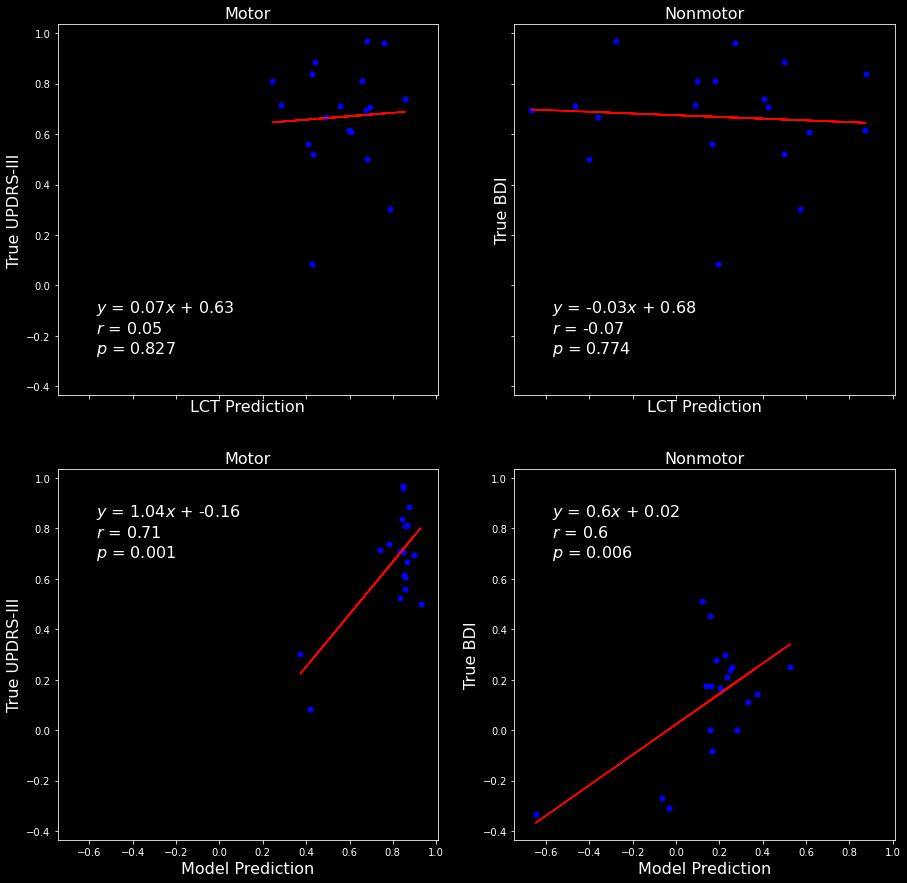

In [14]:
plt.rcParams['figure.figsize'] = [15, 15]
fig,ax = plt.subplots(2,2,sharex=True,sharey=True)
#ax[0].scatter(pre_imp,per_change)
# col = np.where(per_change <= 0.3,'orange','blue')
col = 'blue'
lr = stats.linregress(pre_imp_u[m],per_change_u)
y_model = pre_imp_u[m]*lr.slope+lr.intercept
ax[0,0].plot(pre_imp_u[m],y_model,color='r')
ax[0,0].text(0.1,0.1,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0,0].transAxes,fontsize=16)  
ax[0,0].set_title('Motor',fontsize=16)
ax[0,0].set_ylabel('True UPDRS-III',fontsize=16)
ax[0,0].set_xlabel('LCT Prediction',fontsize=16)
ax[0,0].scatter(pre_imp_u[m],per_change_u, c=col,linewidth=0)
lr = stats.linregress(pre_imp[m],per_change_u)
y_model = pre_imp[m]*lr.slope+lr.intercept
ax[0,1].plot(pre_imp[m],y_model,color='r')
ax[0,1].text(0.1,0.1,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0,1].transAxes,fontsize=16)  
ax[0,1].set_title('Nonmotor',fontsize=16)
ax[0,1].set_xlabel('LCT Prediction',fontsize=16)
ax[0,1].set_ylabel('True BDI',fontsize=16)
# ax[0,1].set_xlabel('Prediction',fontsize=16)
ax[0,1].scatter(pre_imp[m],per_change_u, c=col,linewidth=0)
lr = stats.linregress(results_ls_aug[:,1],per_change_u)
y_model = results_ls_aug[:,1]*lr.slope+lr.intercept
ax[1,0].scatter(results_ls_aug[:,1],per_change_u, c=col,linewidth=0)
ax[1,0].plot(results_ls_aug[:,1],y_model,color='r')
ax[1,0].text(0.1,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1,0].transAxes,fontsize=16)  
ax[1,0].set_title('Motor',fontsize=16)
ax[1,0].set_ylabel('True UPDRS-III',fontsize=16)
ax[1,0].set_xlabel('Model Prediction',fontsize=16)
#col = np.where(per_change <= 0.3,'orange','blue')
ax[1,1].scatter(results_ls_aug[:,0],per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug[:,0]),per_change)
y_model = results_ls_aug[:,0]*lr.slope+lr.intercept
ax[1,1].plot(results_ls_aug[:,0],y_model,color='r')
ax[1,1].text(0.1,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1,1].transAxes,fontsize=16) 
ax[1,1].set_xlabel('Model Prediction',fontsize=16)
ax[1,1].set_ylabel('True BDI',fontsize=16)
ax[1,1].yaxis.set_tick_params(labelleft=True)
ax[1,1].set_title('Nonmotor',fontsize=16)
# plt.ylim([-0.55,0.55])
# plt.xlim([-0.55,0.55])
plt.style.use('default')

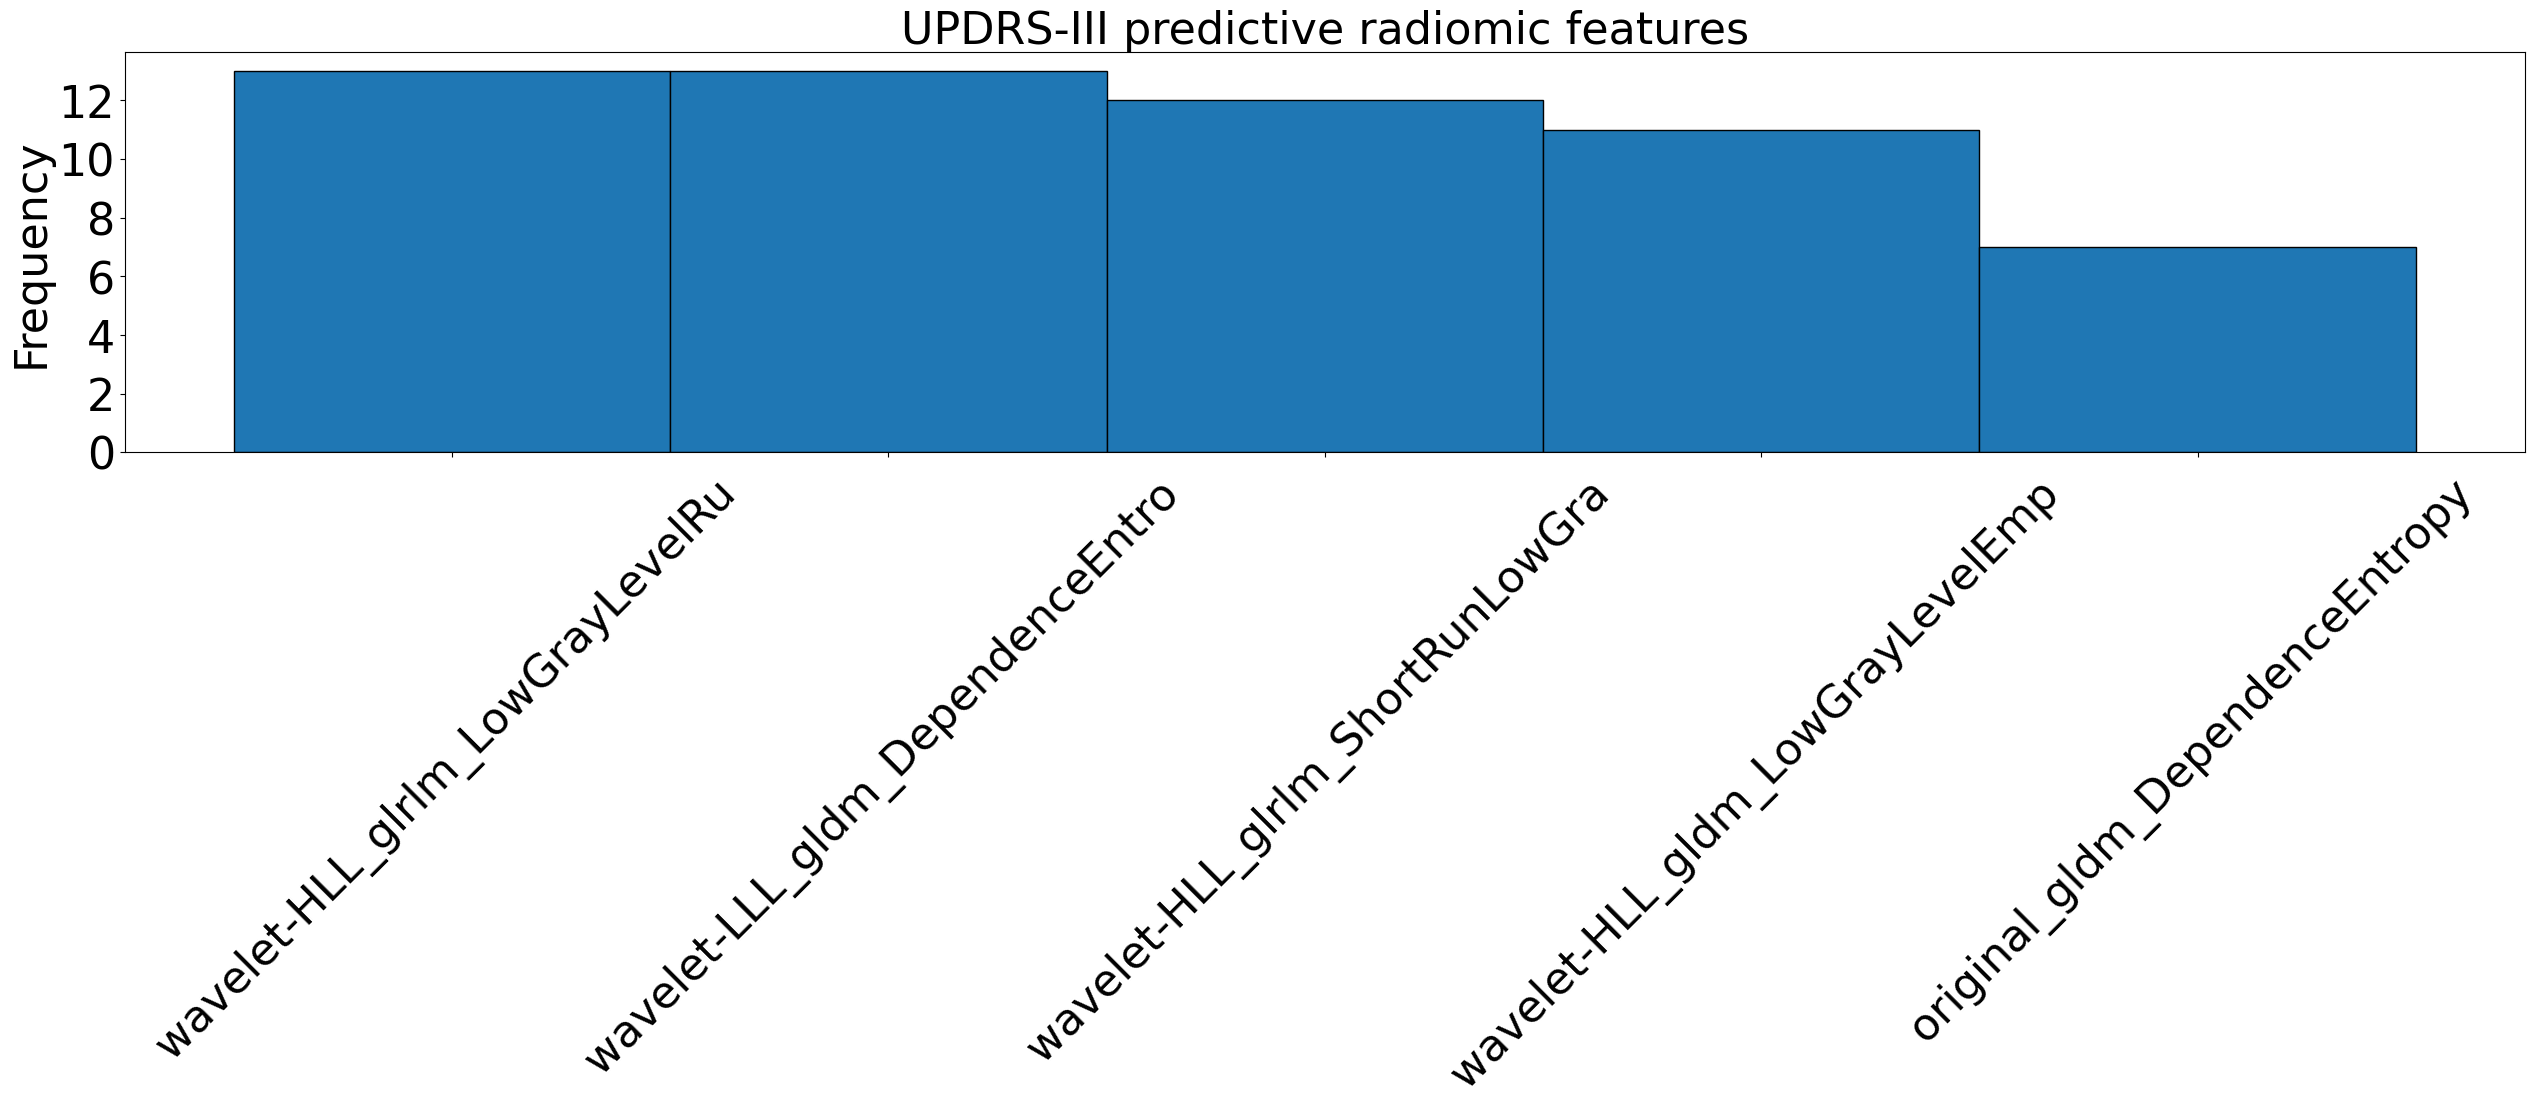

In [15]:
from collections import Counter

plt.rcParams["figure.figsize"] = (30,5)
fig, axes = plt.subplots(1,1,sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

R = [item for sublist in K_nz_m for item in sublist]
letter_counts = Counter(R)
lc = { x: count for x, count in letter_counts.items() if count > 6}
df = pd.DataFrame.from_dict(lc, orient='index')
df.sort_values(0, ascending=False, inplace=True)
df.plot(ax=axes, y=0, kind='bar', legend=False, fontsize=32,stacked=True, width=1, edgecolor='black')
plt.title('UPDRS-III predictive radiomic features',fontsize=32)
plt.ylabel('Frequency',fontsize=32)
plt.xticks(rotation=45)
plt.style.use('default')

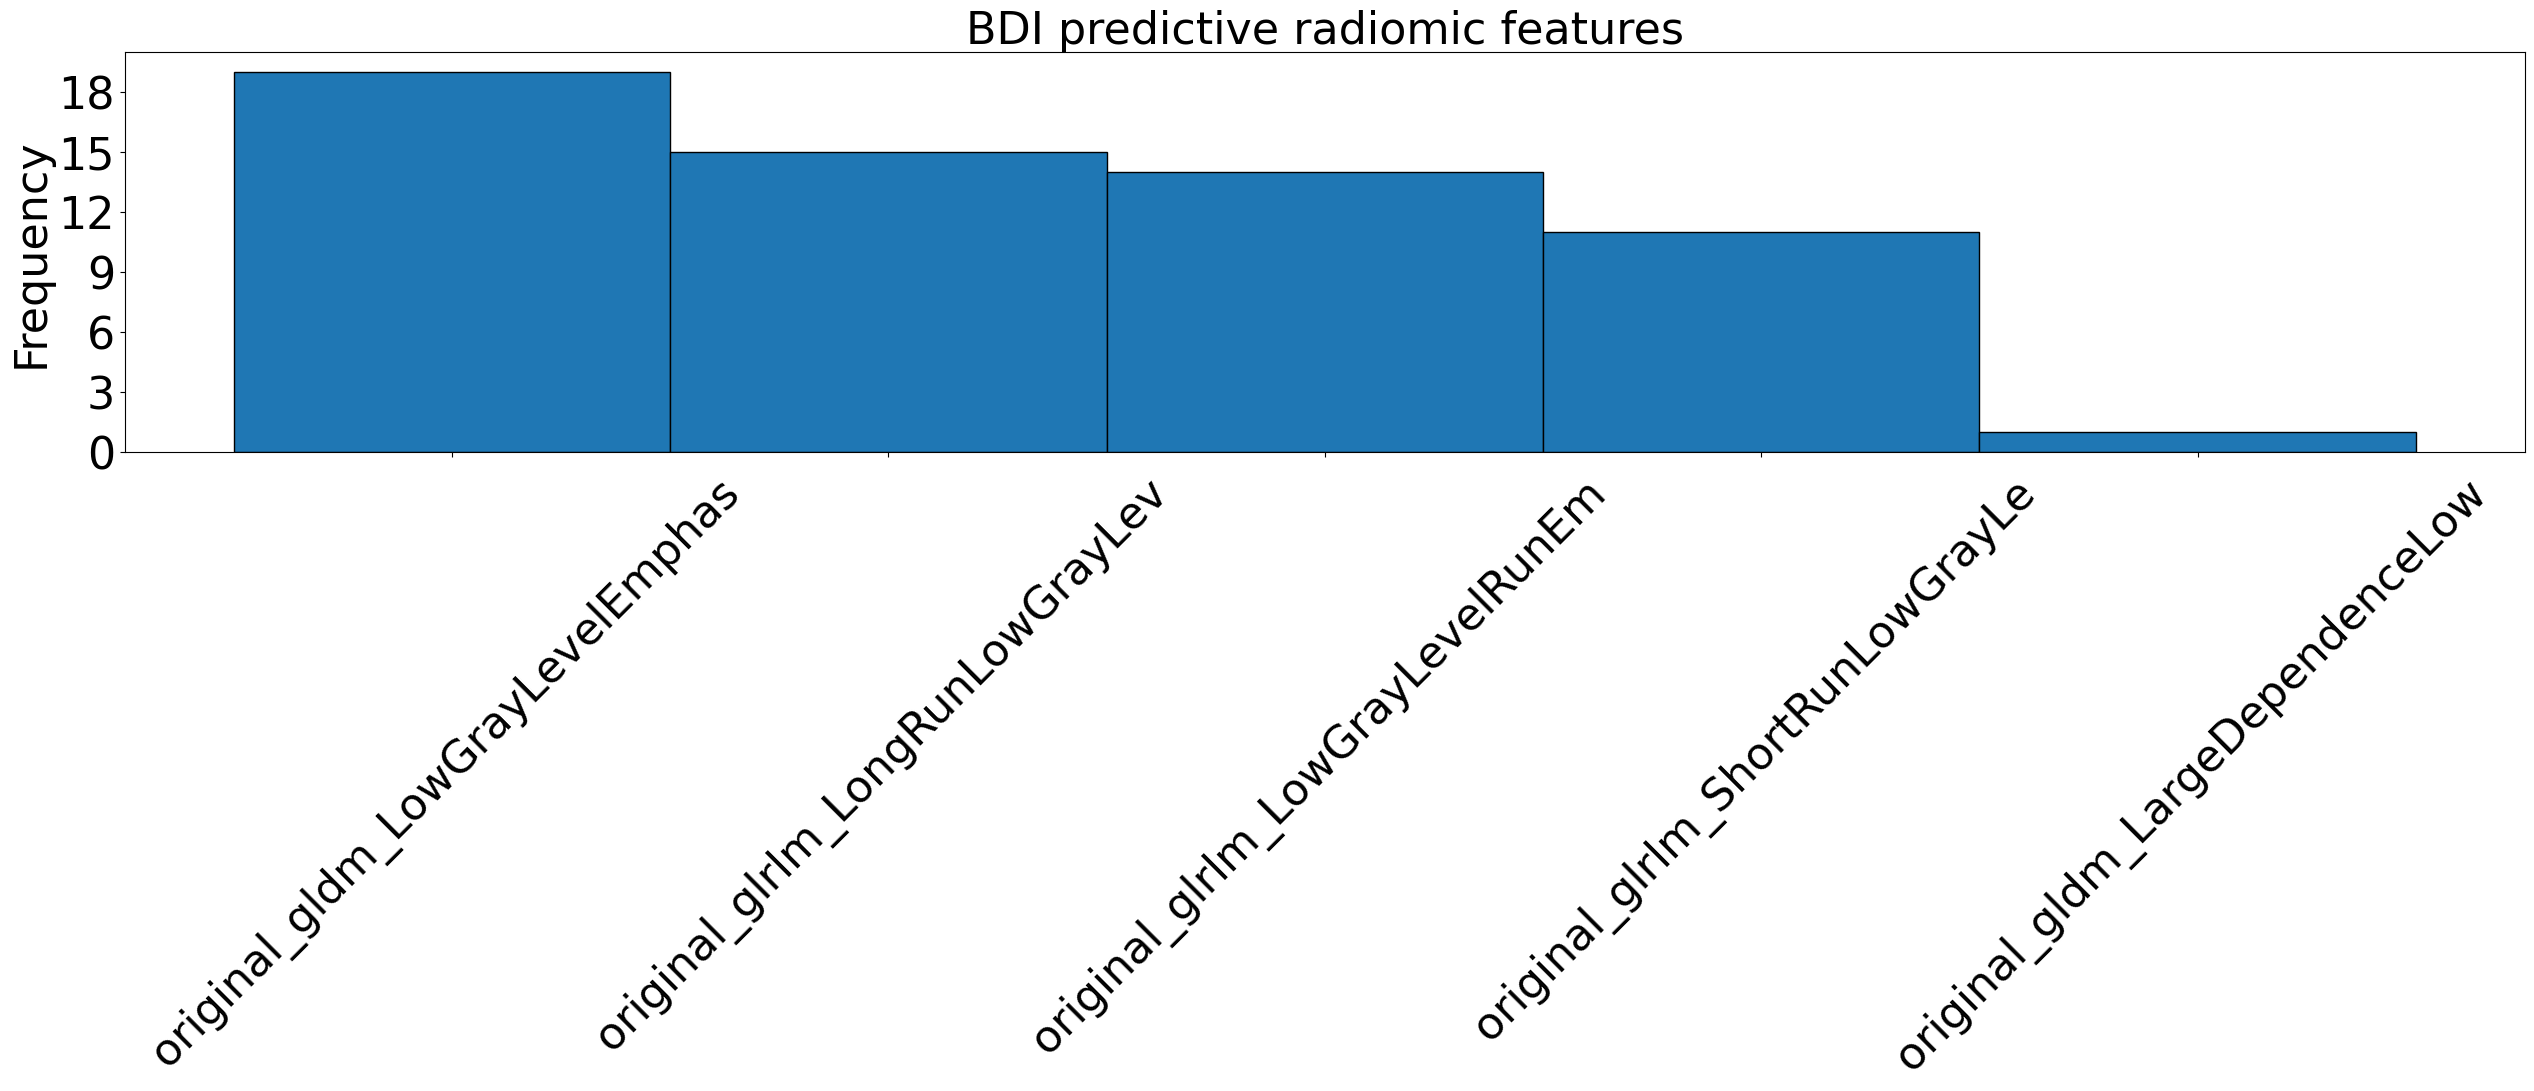

In [16]:
from collections import Counter

plt.rcParams["figure.figsize"] = (30,5)
fig, axes = plt.subplots(1,1,sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

R = [item for sublist in K_nz_nm for item in sublist]
letter_counts = Counter(R)
lc = { x: count for x, count in letter_counts.items() if count > 0}
df = pd.DataFrame.from_dict(lc, orient='index')
df.sort_values(0, ascending=False, inplace=True)
df = df.head(5)
df.plot(ax=axes, y=0, kind='bar', legend=False, fontsize=32, stacked=True, width=1, edgecolor='black')
# Setting integer y-axis ticks
y_ticks = np.arange(0,19,3)  # Adjust range and step as needed
plt.yticks(y_ticks)
plt.title('BDI predictive radiomic features',fontsize=32)
plt.ylabel('Frequency',fontsize=32)
plt.xticks(rotation=45)
plt.style.use('default')

In [17]:
flatten(w_nz_nm)

[0.04497630184969039,
 -0.08306867034755876,
 -0.08651016718694293,
 -0.05138743545152314,
 -0.004473703578137459,
 -0.07083847394273399,
 -0.09926272665258602,
 -0.0003128866536941673,
 -0.011176431927259582,
 -0.06516957258523665,
 -0.09111834805857477,
 -0.09665491284088856,
 -0.024766819441337008,
 -0.04876923176429818,
 -0.007900944050001038,
 -0.06734987299624773,
 -0.09063009215635309,
 -3.838119675503859e-20,
 -0.010148243905229948,
 -0.0669526999960428,
 -0.09144994152452197,
 -5.039907593153742e-20,
 -0.01141386582167244,
 -0.06439614751618,
 -0.09166845280481094,
 -0.04320317079374277,
 -4.407053336591523e-05,
 -0.00986869764577899,
 -0.015760924682067374,
 -0.0017455579252727595,
 -0.010671166174579229,
 -0.06527189015891656,
 -0.09176281995237669,
 -0.012263855966159205,
 -0.06363073034868971,
 -0.09126579079964317,
 -0.011178442543471855,
 -0.06548399450278608,
 -0.09298653634054671,
 -0.03922024486533674,
 -0.03747854187193048,
 -0.0589786932081257,
 1.936135154241648e-1

In [18]:
lc

{'original_gldm_LargeDependenceLow ': 1,
 'original_gldm_LowGrayLevelEmphas ': 19,
 'original_glrlm_LongRunLowGrayLev ': 15,
 'original_glrlm_ShortRunLowGrayLe ': 11,
 'original_glrlm_LowGrayLevelRunEm ': 14,
 'squareroot_gldm_LargeDependenceL ': 1,
 'squareroot_glrlm_LongRunLowGrayL ': 1,
 'wavelet-LLL_gldm_LargeDependence ': 1,
 'wavelet-LLL_gldm_LowGrayLevelEmp ': 1}

In [19]:
beta_1 = np.asarray(flatten(w_nz_nm))[np.asarray(flatten(K_nz_nm))=='original_gldm_LowGrayLevelEmphas ']
beta_2 = np.asarray(flatten(w_nz_nm))[np.asarray(flatten(K_nz_nm))=='original_glrlm_LongRunLowGrayLev ']
beta_3 = np.asarray(flatten(w_nz_nm))[np.asarray(flatten(K_nz_nm))=='original_glrlm_LowGrayLevelRunEm ']

In [20]:
(np.asarray(flatten(K_nz_nm))=='original_glrlm_LongRunLowGrayLev ').astype(int).shape

(64,)

In [21]:
beta_2y = np.asarray(flatten(p_nz))[np.asarray(flatten(K_nz_nm))=='original_glrlm_LongRunLowGrayLev ']

In [22]:
beta_3y = np.asarray(flatten(p_nz))[np.asarray(flatten(K_nz_nm))=='original_glrlm_LowGrayLevelRunEm ']

0.008197535924596131

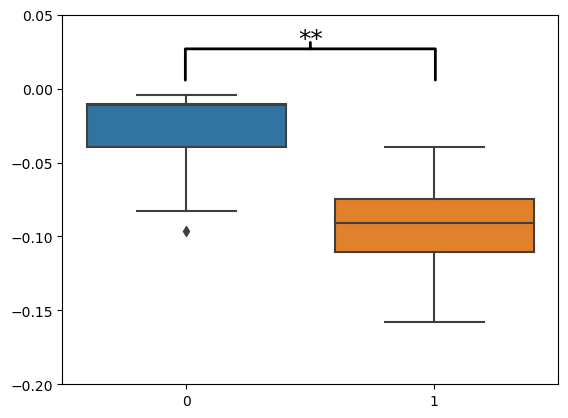

In [23]:
import numpy as np
import seaborn as sns
import scipy
all_arr = [beta_1[per_change>=0],beta_1[per_change<0]]
sns.boxplot(data=all_arr)
# plt.text(1, max(np.max(beta_1[per_change>=0]), np.max(beta_1[per_change<0]))+0.02, "*", ha='center', va='bottom', fontsize=20)
plt.ylim([-0.2,0.05])
plt.annotate('**', xy=(0.5, 0.9), xytext=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=18, ha='center', va='bottom',
            bbox=dict(alpha=0,boxstyle=None, fc='white', color=None),
            arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=1.25', lw=2.0, color='k'))
res = scipy.stats.ranksums(beta_1[per_change>=0], beta_1[per_change<0],alternative='greater')
res.pvalue

In [93]:
K_all[1,1,1:100]

array(['original_shape_Flatness', 'original_shape_LeastAxisLength',
       'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameter',
       'original_shape_Maximum2DDiameter',
       'original_shape_Maximum2DDiameter',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRati',
       'original_shape_VoxelVolume', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile', 'original_firstorder_Energy',
       'original_firstorder_Entropy', 'original_firstorder_Interquartil',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_MeanAbsolute', 'original_firstorder_Mean',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range', 'original_firstorder_RobustMeanAb',
       'original_firstorder_RootMeanSqua', 'or

In [24]:
X_all_c.shape

(19, 2, 1595)

In [25]:
(K_all=='original_gldm_LowGrayLevelEmphas ').shape
K_all_m = K_all[c_cases_idx,:,:][m]
X_all_m = X_all[c_cases_idx,:,:][m]

In [28]:
K_all_m.shape
X_all_m.shape

(19, 6, 1595)

In [32]:
(K_all_m[per_change>=0,4:6,:]=='original_gldm_LowGrayLevelEmphas ').shape

(15, 2, 1595)

In [101]:
x2 = X_all_m[K_all_m=='original_gldm_HighGrayLevelEmpha'].reshape((19,6,-1))

array([[[ 41.38232373386296 ],
        [ 38.6179295624333  ],
        [ 87.32125205930807 ],
        [ 87.32301869991095 ],
        [ 37.29073482428115 ],
        [ 35.72829131652661 ]],

       [[ 96.86090005844535 ],
        [ 48.06543837357052 ],
        [114.87142113482561 ],
        [128.18762376237623 ],
        [ 61.6              ],
        [ 72.56591211717709 ]],

       [[ 64.9674693705112  ],
        [ 47.992656587473   ],
        [153.41717533150916 ],
        [155.93270440251572 ],
        [ 49.26376811594203 ],
        [ 44.10158013544018 ]],

       [[ 67.0130548302872  ],
        [ 38.5486160397445  ],
        [272.47561277543946 ],
        [358.80946291560105 ],
        [120.0561797752809  ],
        [126.18809523809524 ]],

       [[ 65.81310942578548 ],
        [ 39.11349160393746 ],
        [175.93323021397268 ],
        [ 88.0679706601467  ],
        [ 48.54964539007092 ],
        [ 43.18549346016647 ]],

       [[ 47.39491046182847 ],
        [ 38.25561797752809 ]

In [98]:
x1 = X_all_m[K_all_m=='original_gldm_LowGrayLevelEmphas'].reshape((19,6,-1))
xm = X_all_m[K_all_m=='original_firstorder_Mean'].reshape((19,6,-1))
np.mean(xm[per_change>=0]),np.mean(xm[per_change<0])
# res = scipy.stats.ranksums(xm[per_change>=0,4:6,:], xm[per_change<0,4:6,:],alternative='greater')
# from pprint import pprint
# pprint(res)

(150.41859361968042, 112.63414036122124)

RanksumsResult(statistic=9.8, pvalue=5.629282311376514e-23)


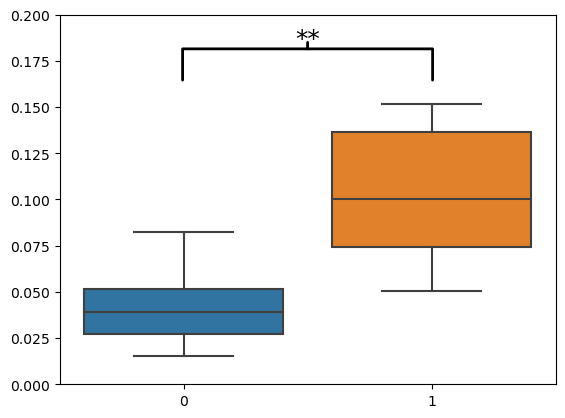

In [76]:
import numpy as np
import seaborn as sns
import scipy
all_arr = [x1[per_change>=0,4:6,:],x1[per_change<0,4:6,:]]
sns.boxplot(data=all_arr)
# plt.text(1, max(np.max(beta_1[per_change>=0]), np.max(beta_1[per_change<0]))+0.02, "*", ha='center', va='bottom', fontsize=20)
plt.ylim([0,0.2])
plt.annotate('**', xy=(0.5, 0.9), xytext=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=18, ha='center', va='bottom',
            bbox=dict(alpha=0,boxstyle=None, fc='white', color=None),
            arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=1.25', lw=2.0, color='k'))
res = scipy.stats.ranksums(x1[per_change>=0,4:6,:], x1[per_change<0,4:6,:],alternative='greater')
from pprint import pprint
pprint(res)

RanksumsResult(statistic=16.3, pvalue=4.934606477065987e-60)


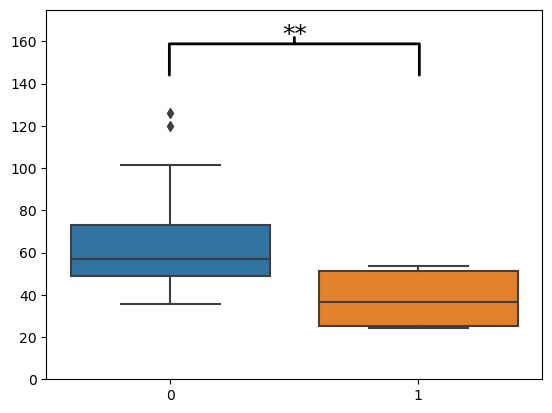

In [106]:
import numpy as np
import seaborn as sns
import scipy
all_arr = [x2[per_change>=0,4:6,:],x2[per_change<0,4:6,:]]
sns.boxplot(data=all_arr)
# plt.text(1, max(np.max(beta_1[per_change>=0]), np.max(beta_1[per_change<0]))+0.02, "*", ha='center', va='bottom', fontsize=20)
plt.ylim([0,175])
plt.annotate('**', xy=(0.5, 0.9), xytext=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=18, ha='center', va='bottom',
            bbox=dict(alpha=0,boxstyle=None, fc='white', color=None),
            arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=1.25', lw=2.0, color='k'))
res = scipy.stats.ranksums(x2[per_change>=0,4:6,:], x2[per_change<0,4:6,:],alternative='greater')
from pprint import pprint
pprint(res)

RanksumsResult(statistic=21.361179742701477, pvalue=1.534801342165918e-101)


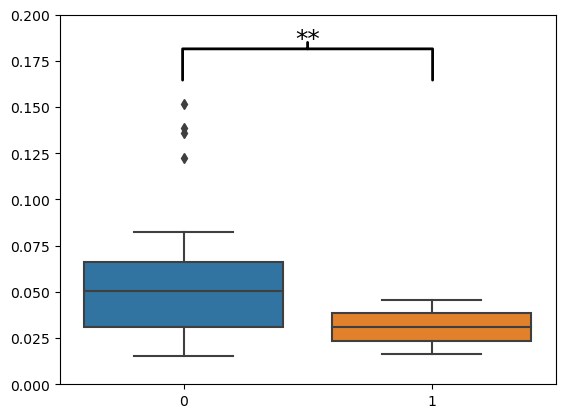

In [ ]:
# UPDRS-III
import numpy as np
import seaborn as sns
import scipy
all_arr = [x1[per_change_u>=0.3,4:6,:],x1[per_change_u<0.3,4:6,:]]
sns.boxplot(data=all_arr)
# plt.text(1, max(np.max(beta_1[per_change>=0]), np.max(beta_1[per_change<0]))+0.02, "*", ha='center', va='bottom', fontsize=20)
plt.ylim([0,0.2])
plt.annotate('**', xy=(0.5, 0.9), xytext=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=18, ha='center', va='bottom',
            bbox=dict(alpha=0,boxstyle=None, fc='white', color=None),
            arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=1.25', lw=2.0, color='k'))
res = scipy.stats.ranksums(x1[per_change_u>=0.3,4:6,:], x1[per_change_u<0.3,4:6,:],alternative='greater')
from pprint import pprint
pprint(res)

0.004874819589726903

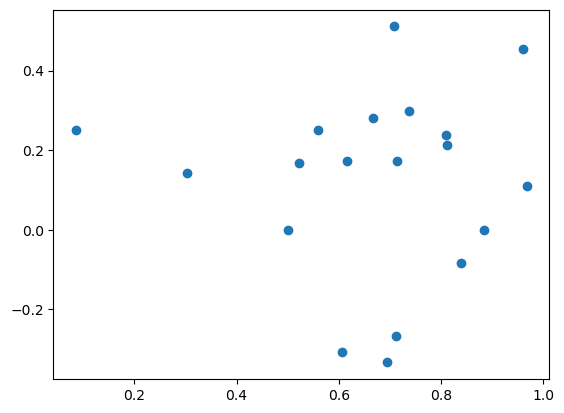

In [80]:
plt.scatter(per_change_u,per_change)
linregress(per_change_u,per_change).rvalue

In [86]:
np.mean(pre_bdi[m][per_change>=0]),np.mean(pre_bdi[m][per_change<0])


(24.933333333333334, 14.5)

RanksumsResult(statistic=1.3, pvalue=0.09680048458561036)


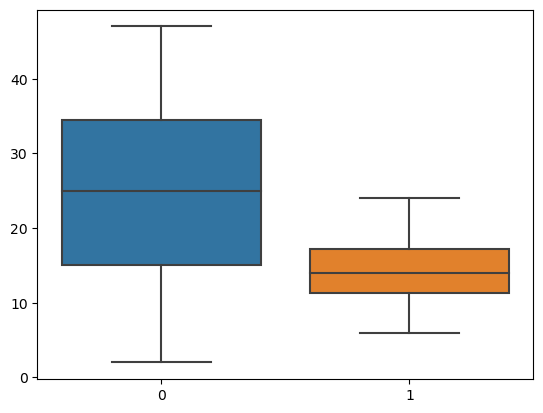

In [84]:
import numpy as np
import seaborn as sns
import scipy
all_arr = [pre_bdi[m][per_change>=0],pre_bdi[m][per_change<0]]
sns.boxplot(data=all_arr)
# plt.text(1, max(np.max(beta_1[per_change>=0]), np.max(beta_1[per_change<0]))+0.02, "*", ha='center', va='bottom', fontsize=20)
# plt.ylim([0,0.2])
# plt.annotate('**', xy=(0.5, 0.9), xytext=(0.5, 0.9), xycoords='axes fraction', 
#             fontsize=18, ha='center', va='bottom',
#             bbox=dict(alpha=0,boxstyle=None, fc='white', color=None),
#             arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=1.25', lw=2.0, color='k'))
res = scipy.stats.ranksums(pre_bdi[m][per_change>=0],pre_bdi[m][per_change<0],alternative='greater')
from pprint import pprint
pprint(res)

0.044714679514496765

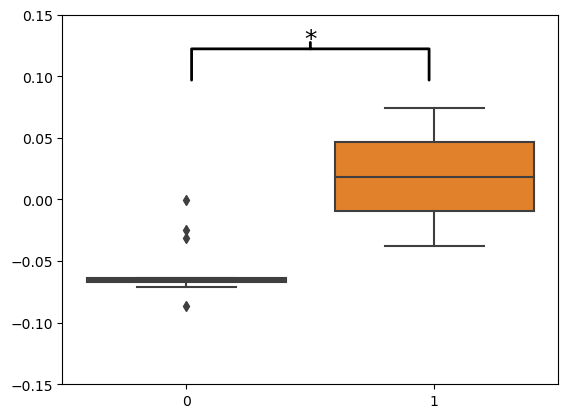

In [48]:
import numpy as np
import seaborn as sns
import scipy
plt.ylim([-0.15,0.15])
plt.annotate('*', xy=(0.5, 0.9), xytext=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=18, ha='center', va='bottom',
            bbox=dict(alpha=0,boxstyle=None, fc='white', color=None),
            arrowprops=dict(arrowstyle='-[, widthB=4.75, lengthB=1.25', lw=2.0, color='k'))
all_arr = [beta_2[beta_2y>0],beta_2[beta_2y<=0]]
sns.boxplot(data=all_arr)
res = scipy.stats.ranksums(beta_2[beta_2y>0], beta_2[beta_2y<=0],alternative='less')
res.pvalue

In [49]:
per_change

array([ 0.5106383 ,  0.        ,  0.28      ,  0.11111111,  0.2972973 ,
        0.17391304,  0.21212121,  0.        ,  0.14285714,  0.23809524,
        0.25      ,  0.16666667, -0.08333333,  0.25      ,  0.45454545,
       -0.26666667, -0.33333333,  0.17391304, -0.30769231])

In [50]:
beta_3y

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False,  True])

0.007903387303651125

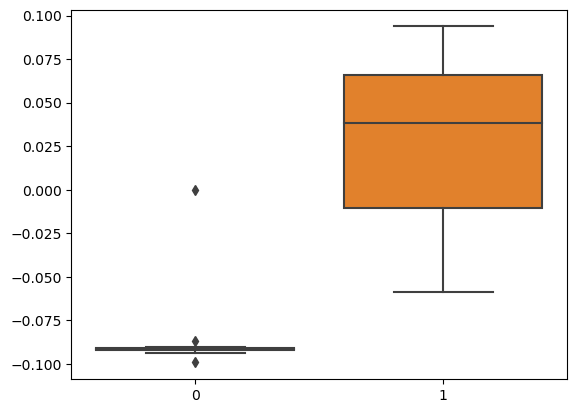

In [51]:
import numpy as np
import seaborn as sns
import scipy
all_arr = [beta_3[beta_3y>0],beta_3[beta_3y<=0]]
sns.boxplot(data=all_arr)
res = scipy.stats.ranksums(beta_3[beta_3y>0], beta_3[beta_3y<=0],alternative='less')
res.pvalue

0.1293677544678406

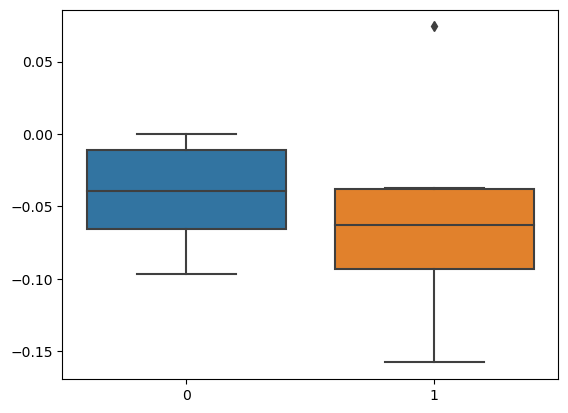

In [52]:
import numpy as np
import seaborn as sns
import scipy
all_arr = [np.hstack((beta_1[per_change>=0],beta_2[beta_2y>0])), np.hstack((beta_1[per_change<0],beta_2[beta_2y<=0]))]
sns.boxplot(data=all_arr)
res = scipy.stats.ranksums(np.hstack((beta_1[per_change>=0],beta_2[beta_2y>0])), np.hstack((beta_1[per_change<0],beta_2[beta_2y<=0])),alternative='greater')
res.pvalue

0.2502941069314704

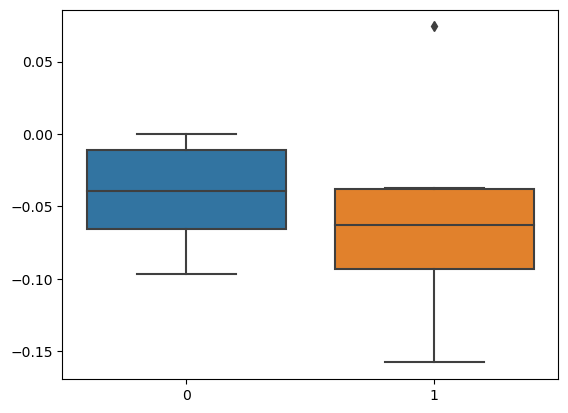

In [ ]:
import numpy as np
import seaborn as sns
import scipy
all_arr = [np.hstack((beta_1[per_change>=0],beta_2[beta_2y>0])), np.hstack((beta_1[per_change<0],beta_2[beta_2y<=0]))]
sns.boxplot(data=all_arr)
res = scipy.stats.ranksums(np.hstack((beta_1[per_change>=0],beta_2[beta_2y>0],beta_3[beta_3y>0])), np.hstack((beta_1[per_change<0],beta_2[beta_2y<=0],beta_3[beta_3y<=0])),alternative='less')
res.pvalue

In [54]:
# np_nz = [not elem for elem in flatten(p_nz)]
# print(len(flatten(w_nz_nm)))
# res = scipy.stats.ranksums(np.asarray(flatten(w_nz_nm))[flatten(p_nz)],np.asarray(flatten(w_nz_nm))[np_nz])
# res.pvalue

In [55]:
linregress(per_change_u,results_ls_aug[:,1]).rvalue

0.7114307874013871

In [56]:
linregress(pre_imp_u[m],results_ls_aug[:,1]).rvalue

-0.05851066846796051

In [57]:
linregress(pre_imp_u[m],per_change_u).rvalue

0.05385751898413298

In [58]:
len(pre_imp_u[m])

19

In [59]:
per_change_u

array([0.70769231, 0.5       , 0.66666667, 0.96825397, 0.73809524,
       0.71428571, 0.8125    , 0.88461538, 0.3030303 , 0.81081081,
       0.55932203, 0.52272727, 0.83928571, 0.08571429, 0.96      ,
       0.71111111, 0.69491525, 0.61702128, 0.60655738])

In [60]:
results_ls_aug[:,1]

array([0.84524533, 0.92849747, 0.8628888 , 0.84743741, 0.7813094 ,
       0.74043392, 0.86331119, 0.87320852, 0.37325329, 0.85744061,
       0.85501488, 0.83350451, 0.84112804, 0.4177645 , 0.84856857,
       0.83359191, 0.89647819, 0.85288766, 0.85447826])

In [61]:
from CorrelationStats import corrstats
corrstats.dependent_corr(linregress(per_change_u,results_ls_aug[:,1]).rvalue,linregress(per_change_u,pre_imp_u[m]).rvalue,linregress(pre_imp_u[m],results_ls_aug[:,1]).rvalue,len(pre_imp_u[m]),twotailed=False,conf_level=0.95,method='steiger')

(2.41107779280537, 0.014144147555225084)

In [62]:
np.mean(age),np.std(age)
np.sum(sex)
np.mean(dd),np.std(dd)
np.mean(ledd),np.std(ledd)
np.mean(cv_dict[' OFF (pre-dbs updrs)']),np.std(cv_dict[' OFF (pre-dbs updrs)'])
np.mean(cv_dict[' ON (pre-dbs updrs)']),np.std(cv_dict[' ON (pre-dbs updrs)'])
np.mean(cv_dict[' OFF meds ON stim 6mo']),np.std(cv_dict[' OFF meds ON stim 6mo'])
np.nanmean((ledd-p_ledd)/ledd),np.nanstd((ledd-p_ledd)/ledd)

(0.7724137178472388, 0.2556740846963942)